In [1]:
import matplotlib.pyplot as plt
%matplotlib inline  
import matplotlib.pylab as pylab

import numpy as np
import pandas as pd

columns = ["symboling","normalized-losses","make","fuel-type",
           "aspiration","num-of-doors","body-style","drive-wheels",
           "engine-location","wheel-base","length","width","height",
           "curb-weight","engine-type","num-of-cylinders",
           "engine-size","fuel-system","bore","stroke",
           "compression-ratio","horsepower","peak-rpm","city-mpg",
           "highway-mpg","price"]

dataset = pd.read_csv('./autos/imports-85.data', na_values="?", names=columns)

In [2]:
print(dataset.head())

   symboling  normalized-losses         make fuel-type aspiration  \
0          3                NaN  alfa-romero       gas        std   
1          3                NaN  alfa-romero       gas        std   
2          1                NaN  alfa-romero       gas        std   
3          2                164         audi       gas        std   
4          2                164         audi       gas        std   

  num-of-doors   body-style drive-wheels engine-location  wheel-base  ...    \
0          two  convertible          rwd           front        88.6  ...     
1          two  convertible          rwd           front        88.6  ...     
2          two    hatchback          rwd           front        94.5  ...     
3         four        sedan          fwd           front        99.8  ...     
4         four        sedan          4wd           front        99.4  ...     

   engine-size  fuel-system  bore  stroke compression-ratio horsepower  \
0          130         mpfi  3.47   

In [3]:
dataset.dtypes

symboling              int64
normalized-losses    float64
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                 float64
stroke               float64
compression-ratio    float64
horsepower           float64
peak-rpm             float64
city-mpg               int64
highway-mpg            int64
price                float64
dtype: object

In [4]:
from sklearn.preprocessing import LabelEncoder


words_to_nums = {'two':2, 'three':3, 'four':4, 'five':5, 
                 'six':6, 'eight':8, 'twelve':12}

columns_to_map = ['num-of-cylinders', 'num-of-doors']
columns_to_dummy = ['make', 'body-style', 'drive-wheels', 
                    'engine-type', 'fuel-system']
columns_to_label_encode = ['fuel-type', 'aspiration', 
                           'engine-location']

for col in columns_to_map:
    dataset[col] = dataset[col].map(pd.Series(words_to_nums))

for col in columns_to_label_encode:
    dataset[col] = LabelEncoder().fit_transform(dataset[col])

dataset = pd.get_dummies(dataset, columns=columns_to_dummy)

dataset.shape

(205, 66)

In [5]:
ranks = dataset['symboling'].as_matrix()
observations = dataset.drop('symboling', axis=1).as_matrix()

In [6]:
#observations still contain NaN -> substitute it with the median
from sklearn.preprocessing import Imputer
imp = Imputer(strategy="median", axis=0)
observations = imp.fit_transform(observations)

In [7]:
observations.shape

(205, 65)

In [8]:
from sklearn.cross_validation import StratifiedKFold

kf = StratifiedKFold(ranks, 4, shuffle=True, random_state=101)
idxs = list(kf)[0]

X_train = observations[idxs[0], :]
X_test = observations[idxs[1], :]
y_train = ranks[idxs[0]]
y_test = ranks[idxs[1]]


In [9]:
def prediction_to_probas(class_pred):
    
    probas = []
    for el in class_pred:
        prob = [0.]*6
        prob[el+2] = 1.0
        probas.append(prob)
    return np.array(probas)

def check_estimator(estimator):
        assert sum(
            np.abs(clf.classes_ - np.array([-2, -1, 0, 1, 2, 3]))
        ) == 0

In [10]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=101)
clf.fit(X_train, y_train)
check_estimator(clf)

y_test_proba = prediction_to_probas(y_test)
y_pred_proba = clf.predict_proba(X_test)

In [11]:
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.metrics import label_ranking_loss

print("Ranking loss:", label_ranking_loss(y_test_proba, y_pred_proba))
print("Ranking avg precision:", label_ranking_average_precision_score(y_test_proba, y_pred_proba))

Ranking loss: 0.101886792453
Ranking avg precision: 0.817610062893


In [12]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.cross_validation import StratifiedShuffleSplit

def scorer(estimator, X, y):
    
    check_estimator(estimator)
    y_proba = prediction_to_probas(y)
    return -1*label_ranking_loss(y_proba, estimator.predict_proba(X))


params = {'C': np.logspace(-1, 1, 10)
         }


cv = StratifiedShuffleSplit(y_train, random_state=101, 
                            n_iter=5, train_size=0.70)
gs_cv = GridSearchCV(LogisticRegression(random_state=101),
                     param_grid=params,
                     n_jobs=1,
                     cv=cv,
                     scoring=scorer)

gs_cv.fit(X_train, y_train)
clf = gs_cv.best_estimator_

y_pred_proba = clf.predict_proba(X_test)

print("Ranking loss:", label_ranking_loss(y_test_proba, y_pred_proba))
print("Ranking avg precision:", label_ranking_average_precision_score(y_test_proba, y_pred_proba))

Ranking loss: 0.0905660377358
Ranking avg precision: 0.838050314465


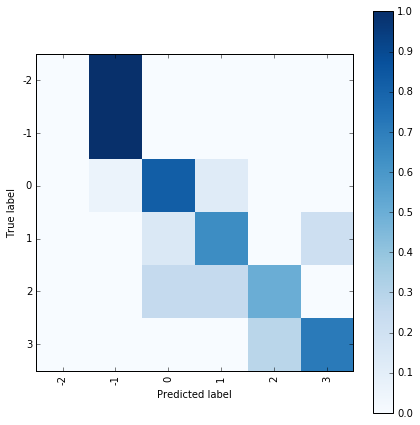

In [13]:
from sklearn.metrics import confusion_matrix

def plot_normalised_confusion_matrix(cm):
    labels_str = [str(n) for n in range(-2, 4)]
    pylab.rcParams['figure.figsize'] = (6.0, 6.0)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(labels_str))
    plt.xticks(tick_marks, labels_str, rotation=90)
    plt.yticks(tick_marks, labels_str)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

plot_normalised_confusion_matrix(confusion_matrix(y_test, clf.predict(X_test)))

